<a href="https://colab.research.google.com/github/rajivsam/interactive_tutorials/blob/master/notebooks/Graph_Retail_Descriptive_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

%%capture
!git clone https://github.com/rajivsam/interactive_tutorials.git
!rsync -av interactive_tutorials/notebooks/data  interactive_tutorials/notebooks/img  interactive_tutorials/notebooks/tools ./ --exclude=.git
!pip install python-arango
!pip install arangopipe==0.0.6.9.5
!pip install pandas PyYAML==5.1.1 sklearn2
!pip install jsonpickle
!pip3 install networkx
!pip3 install matplotlib
!pip3 install adbnx-adapter

In [2]:
! chmod a+x tools/* 

## Methodology Overview

This notebook provides the descriptive features of the frequent customer group. These features are obtained by applying graph analytic concepts to the frequent customer group. To do so, we need to represent the frequent customer group as a graph. In particular, this group is modeled as a bi-partite graph with the customer nodes and item nodes forming the two disjoint vertex sets. The purchase of an item by a customer as part of an invoice is modeled as an edge.

![](https://github.com/rajivsam/interactive_tutorials/blob/master/notebooks/img/bi_partite_graph.png?raw=1)


This notebook will use ideas from:

1.    [Statistical Analysis of Network Data](https://bigdata.unl.edu/documents/ASA_Workshop_Materials/Tutorial%20Statistical%20Analysis%20of%20Network%20Data.pdf): Provides a methodology for characterizing network structure
2.   [Basic Notions for the Analysis of Affiliate Networks](https://github.com/arangoml/networkx-adapter/blob/master/bipartite_clustering.pdf) : Provides a methodology for analyzing bi-partite graphs

The descriptive characteristics of the graph are captured by:


1.   Vertex and Edge Characteristics
2.   Network Cohesion

These perspectives are important because:


1.   They provide insights about customer behavior or the concept modeled by the 
2.   The provide the basis for developing other machine learning tasks for the problem. For example, we may be interested in the following:
*    How can we develop a generative model for the graph 
*   How do we model the formation of links in the network

These tasks tell us how customers make purchases. For details of developing a generative model on bipartite graphs, see [Bipartite Graphs as Models of Complex Networks](http://denif.ens-lyon.fr/data/algorithmique_reseaux_telecoms_enslyon/2007/cours/biparti.pdf) and [Measuring and Modeling Bipartite Graphs with Community Structure](https://www.osti.gov/servlets/purl/1561802). Developing these models requires the descriptive characterization of the graph, which is what is done in this notebook. This chararacterization provides information about properties such as degree distribution and clustering characteristics of nodes which are used to develop the models discussed.

While summary statistics and distributions can be used to provide one descriptive perspective of the network (vertex and edge characteristics), information about grouping characteristics provides the complimentary perspective (network-cohesion). There are multiple ways to describe network-cohension. In this notebook, we will describe two ways to capture or describe cohesive tendencies in the notebook. These are the number of connected components in the graph and measurements describing clique formation in the graph.

The rest of the notebook will provide the implementation of the methodology discussed here. There is one other conceptual idea that we require in the toolbox for the analysis of bi-partite graphs. This is the notion of a _projected graph_.  The two disjoint vertex sets are called the top and bottom vertex sets. The choice of which set to call the top set is arbitrary. It is possible to determine a _projection_ of a set of vertices belonging to either the top or bottom vertex set onto the opposite vertex set. In other words, it is possible to _project_ a set of top vertices on to the bottom vertex set, or, vice versa. The projection of the top set of vertices on to the bottom set, we connect two vertices of the bottom set in the projected graph if they are linked by a vertex in the opposite set. An example graph and the projection graph of the top set of vertices to the bottom set is shown below.


![](https://github.com/rajivsam/interactive_tutorials/blob/master/notebooks/img/projection_graph.png?raw=1)

The customer and the item projection graph have meaningful interpretations. This is discussed when these graphs are generated. The process followed in this notebook to implement this methodology is discussed above is shown below.




![](https://github.com/rajivsam/interactive_tutorials/blob/master/notebooks/img/notebook_3_flow_chart.png?raw=1)

## Read Graph Data

An arango DB graph image from the previous excercise in this series is the starting point for this excercise. We connect to an Oasis instance that will be used for this excercise. 

In [3]:
from arangopipe.arangopipe_storage.arangopipe_api import ArangoPipe
from arangopipe.arangopipe_storage.arangopipe_admin_api import ArangoPipeAdmin
from arangopipe.arangopipe_storage.arangopipe_config import ArangoPipeConfig
from arangopipe.arangopipe_storage.managed_service_conn_parameters import ManagedServiceConnParam
mdb_config = ArangoPipeConfig()
msc = ManagedServiceConnParam()
conn_params = { msc.DB_SERVICE_HOST : "arangoml.arangodb.cloud", \
                        msc.DB_SERVICE_END_POINT : "createDB",\
                        msc.DB_SERVICE_NAME : "createDB",\
                        msc.DB_SERVICE_PORT : 8529,\
                        msc.DB_CONN_PROTOCOL : 'https',\
                        msc.DB_REPLICATION_FACTOR: 3}
        
mdb_config = mdb_config.create_connection_config(conn_params)
admin = ArangoPipeAdmin(reuse_connection = False, config = mdb_config)
ap_config = admin.get_config()
ap = ArangoPipe(config = ap_config)
proj_info = {"name": "Retail_Graph_Analytics"}
proj_reg = admin.register_project(proj_info)
mdb_config.get_cfg()

API endpoint: https://arangoml.arangodb.cloud:8529/_db/_system/createDB/createDB


/home/admin2/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py:1004: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning,


Host Connection: https://arangoml.arangodb.cloud:8529


{'arangodb': {'DB_service_host': 'arangoml.arangodb.cloud',
  'DB_end_point': 'createDB',
  'DB_service_name': 'createDB',
  'DB_service_port': 8529,
  'conn_protocol': 'https',
  'arangodb_replication_factor': 3,
  'dbName': 'MLz10iqjfuq6fcq7mzdp3ta5',
  'username': 'MLf9aqoq3l7ni5ff5nyezgxd',
  'password': 'MLzk2e9344s7b5uoijw6xu'},
 'mlgraph': {'graphname': 'enterprise_ml_graph'}}

In [4]:
conn = mdb_config.get_cfg()
login = conn['arangodb']

In [5]:
login

{'DB_service_host': 'arangoml.arangodb.cloud',
 'DB_end_point': 'createDB',
 'DB_service_name': 'createDB',
 'DB_service_port': 8529,
 'conn_protocol': 'https',
 'arangodb_replication_factor': 3,
 'dbName': 'MLz10iqjfuq6fcq7mzdp3ta5',
 'username': 'MLf9aqoq3l7ni5ff5nyezgxd',
 'password': 'MLzk2e9344s7b5uoijw6xu'}

In [6]:
!chmod -R 755 ./tools/*

In [7]:
# Restore an ArangoDB dump into the database.
!./tools/arangorestore  -c none --server.endpoint  http+ssl://{login["DB_service_host"]}:{login["DB_service_port"]} --server.username {login["username"]} \
--server.database {login["dbName"]} \
--server.password {login["password"]} \
--replication-factor 3  \
--input-directory "data/retail_freq_cust_data_dump_eonb2"

2021-06-17T08:42:03Z [117809] INFO [05c30] {restore} Connected to ArangoDB 'http+ssl://arangoml.arangodb.cloud:8529'
2021-06-17T08:42:05Z [117809] INFO [abeb4] {restore} Database name in source dump is 'MLlsy9bo5km1qveu1018894'
2021-06-17T08:42:05Z [117809] INFO [9b414] {restore} # Re-creating document collection 'Customers'...
2021-06-17T08:42:06Z [117809] INFO [9b414] {restore} # Re-creating document collection 'datasets'...
2021-06-17T08:42:07Z [117809] INFO [9b414] {restore} # Re-creating document collection 'deployment'...
2021-06-17T08:42:08Z [117809] INFO [9b414] {restore} # Re-creating document collection 'devperf'...
2021-06-17T08:42:09Z [117809] INFO [9b414] {restore} # Re-creating document collection 'featuresets'...
2021-06-17T08:42:09Z [117809] INFO [9b414] {restore} # Re-creating document collection 'Items'...
2021-06-17T08:42:10Z [117809] INFO [9b414] {restore} # Re-creating document collection 'modelparams'...
2021-06-17T08:42:11Z [117809] INFO [9b414] {restore} # Re-cr

2021-06-17T08:42:27Z [117809] INFO [6ae09] {restore} # Successfully restored edge collection 'run_modelparams'
2021-06-17T08:42:27Z [117809] INFO [94913] {restore} # Loading data into edge collection 'run_models', data size: 206 byte(s)
2021-06-17T08:42:27Z [117809] INFO [6ae09] {restore} # Successfully restored edge collection 'run_models'
2021-06-17T08:42:29Z [117809] INFO [6ae09] {restore} # Successfully restored edge collection 'Purchases'
2021-06-17T08:42:29Z [117809] INFO [a66e1] {restore} Processed 23 collection(s) in 26.790047 s, read 738550 byte(s) from datafiles, sent 17 data batch(es) of 738533 byte(s) total size


## Create Networkx Graph from ArangoDB Graph

For this excercise, we will use the features of the Networkx library to perform the descriptive characterization of the graph. To do so, we will need a Networkx representation of the frequent customer graph. This can be obtained using the Networkx Adapter. To create the networkx graph, we need to provide the Networkx adapter with the following information:
1. Connection information to the ArangoDB database that contains the graph that we want to covert to a Networkx graph
2. Structural information to create the graph. A description of the vertex and edge collections of the graph in ArangoDB need to be provided.

When this information is supplied to the adapter, the adapter creates an instance of a NetworkX graph and returns it. This instance is used for the rest of the analysis in this excercise.


In [8]:
import networkx as nx
from adbnx_adapter.arangoDB_networkx_adapter import ArangoDB_Networkx_Adapter

# Specify the connection to the ArangoDB Database
con = {'dbName': login["dbName"],
 'username': login["username"],
 'password': login["password"],
 'hostname': login["DB_service_host"],
 'port': login["DB_service_port"]}

# Create Adapter instance
ma = ArangoDB_Networkx_Adapter(conn = con)

freq_customers = {'vertexCollections': {'Customers': {},
                                         'Items': {}},
                   'edgeCollections': {'Purchases': {'_from', '_to', 'spend'}}}

# Export networkX graph                                  
g = ma.create_networkx_graph(graph_name = '',  graph_attributes = freq_customers)


## Generate Vertex and Edge Characteristics

In this section, the vertex and edge characteristics of frequent customer bi-partite graph are computed.

To begin with we will compute the summary statistics of the bi-partite graph and we will generate the degree distribution of the two vertex sets, the customer and the item vertex sets for this graph. The details of performing this with Networkx are shown below. 




### Compute summary statistics for the bi-partite graph

In [9]:
gp = g.to_undirected()

In [10]:
cust_nodes = [n for n in g.nodes() if n.startswith("Customers")]
item_nodes = [n for n in g.nodes() if n.startswith("Items")]

In [11]:
len(cust_nodes)

447

In [12]:
len(item_nodes)

75

In [13]:
len(g.edges())

4475

In [14]:
gp.is_directed()

False

### Compute Distributions of Customer and Item Vertex Sets
We first create a bi-partite version of the graph in networkx. The earlier graph did not discriminate the type of the node. We do that now using the bi-partite graph abstraction available in networkx.

In [15]:
import networkx as nx
B = nx.Graph()
B.add_nodes_from(cust_nodes, bipartite=0)
B.add_nodes_from(item_nodes, bipartite=1)
B.add_edges_from(list(gp.edges()))

In [16]:
from networkx.algorithms import bipartite
degc, degi = bipartite.degrees(B, item_nodes)
dc = [v for k,v in degc]
di = [v for k,v in degi]

#### Customer Degree Distribution

Text(0.5, 0, 'Customer Degree')

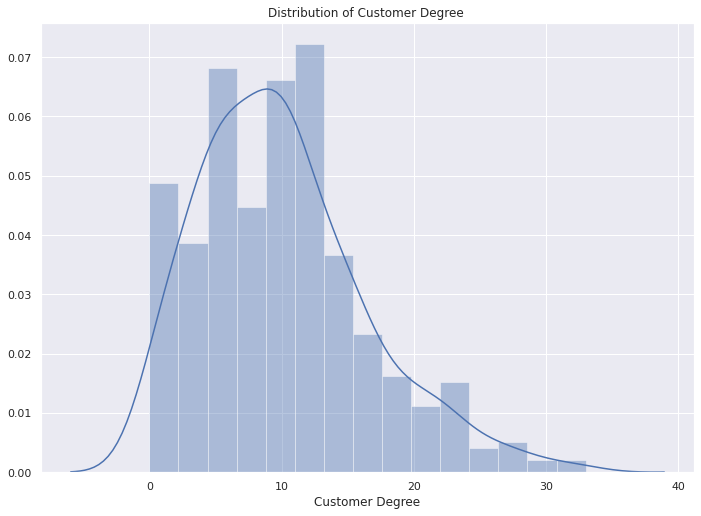

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.distplot(dc, hist = True)
plt.title("Distribution of Customer Degree ")
plt.xlabel("Customer Degree")

#### Item Degree Distribution

Text(0.5, 0, 'Item Degree')

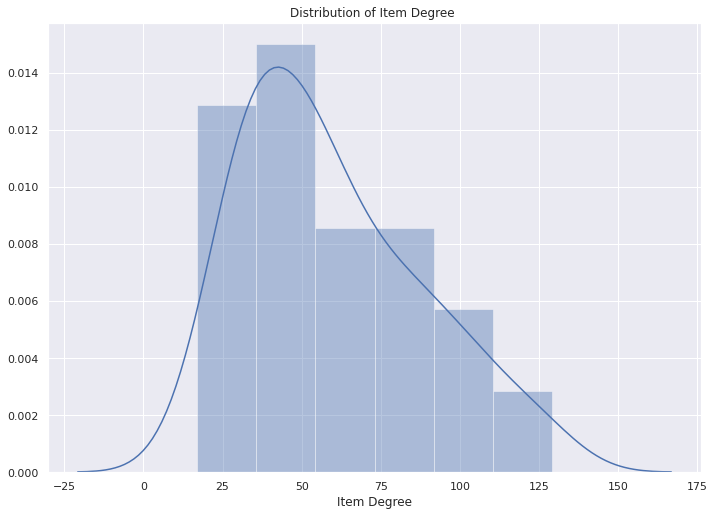

In [18]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.distplot(di, hist = True)
plt.title("Distribution of Item Degree ")
plt.xlabel("Item Degree")

In [19]:
ci = bipartite.clustering(B, item_nodes)

In [20]:
cv = [v for k, v in ci.items()]

Text(0.5, 0, 'Item Clustering Coefficient')

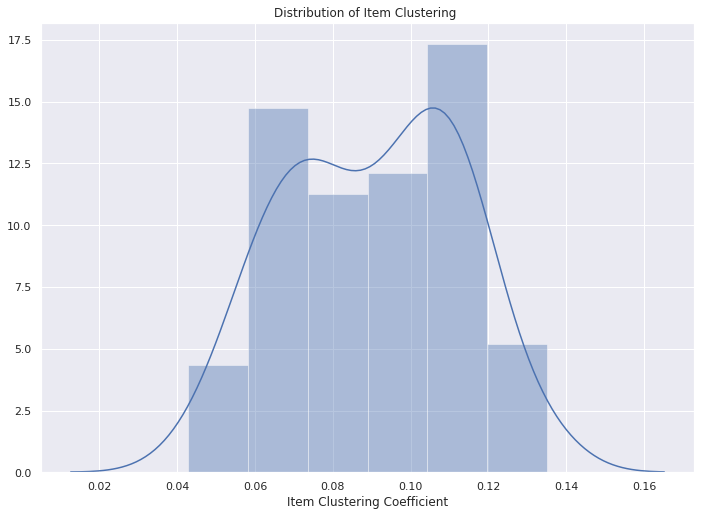

In [21]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.distplot(cv, hist = True)
plt.title("Distribution of Item Clustering ")
plt.xlabel("Item Clustering Coefficient")

### Observations


1.   Random networks do not display clustering tendencies. An examination of the clustering coefficients associated with the item nodes clearly shows clustering tendencies. Therefore, this elminates a random graph as a possible genrative model for this graph.
2.   The degree distribution for the customer and item nodes are non-monotonic as would be observed if either of these nodes show scale-free or power law behavior. In such a case a small set of nodes will act as hubs and have very high degress while most nodes have low degrees. Instead what we observe is that most nodes have similar degrees and a small set of nodes corresponding to both tails have either small or high degrees. This is consistent with _small world networks_ .
3. This implies that most customers buy about the same range of items. For example, a review of the item degree graph shows that most items are bought between 25-75 people, but there a few items that are bought by many people and a few items that are not bought by many people.



## Projection Graphs
The other perspective in characterizing bipartite graphs are the characteristics of the projection graphs. The notion of the projection graph was described in the methodological overview section. We will now generate this projections for the frequent shopper group.

In [22]:
cust_graph = nx.bipartite.projected_graph(B, cust_nodes)
item_graph = nx.bipartite.projected_graph(B, item_nodes)

### Observations
In the customer projection graph, two nodes are connected if they have purchased an item in common. Similarly, in the item projection graph, two items are connected if they have been purchased by a customer. This implies


1.   The customer projection graph captures shared customer taste in purchases. If we pick any random node in the customer projection graph, then the users who are connected by an edge to him or her are those who share at least one purchase. A user who does not share an edge with a user is one whose shopping preferences are different. 
2.   The item projection graph captures copurchased behavior in items. If two items are connected in the item projection graph, it implies that these items were purchased by a customer. If we pick a random item in the item projection graph, following the edges connected to it tells us the items purchased with it. Items not connected to it are not purchased with it.




#### Degree distribution of Customer Graph

In [23]:
dc = nx.degree(cust_graph)
dcv = [ v for k, v in dc]

Text(0.5, 0, 'Degree Distribution of Customer Projection Graph')

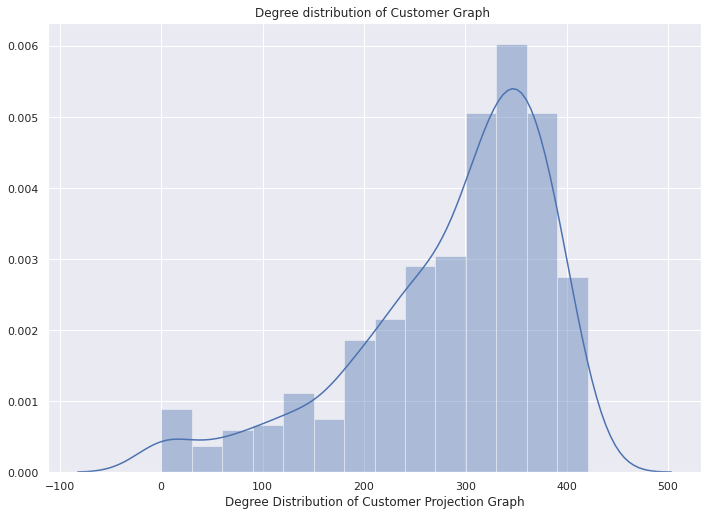

In [24]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.distplot(dcv, hist = True)
plt.title("Degree distribution of Customer Graph ")
plt.xlabel("Degree Distribution of Customer Projection Graph")

#### Observation
The frequent shopper group has a very high degree of shared taste. If we pick a random user in the graph, he or she is connected to hundreds (the peak density is at around 350) of other users. This implies they have a similar taste in products they purchase.

#### Degree Distribution of the Item Projection Graph

In [25]:
di = nx.degree(item_graph)
div = [ v for k, v in di]

Text(0.5, 0, 'Degree Distribution of Item Projection Graph')

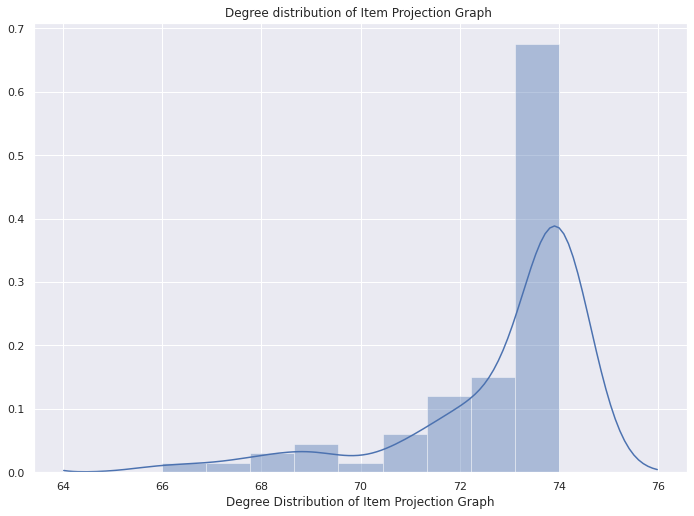

In [26]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.distplot(div, hist = True)
plt.title("Degree distribution of Item Projection Graph ")
plt.xlabel("Degree Distribution of Item Projection Graph")

#### Observation
Similar to the projection graph for the customer, the projection graph for the items show a very high degree of co-purchasing behavior. If we pick any random item it is bound to be purchased with most of the other items in the store.

### Observation
Since it is not uncommon to have nodes with high degrees in both the customer and item projection graph, we should expect to see cliques in this graph.



#### Observation
Since the customer and item projection graph are highly interconnected and since we know we are not working with a power law graph, we don't explore centraility measures. We know that most users and items have a similar range of degrees.


## Network Cohesion

We described the vertex and edge characteristics of the graph representation associated with the frequent shopper group. In doing so, we already discovered that this group is homogeneous with a lot of shared taste. The other perspective to characterize the graph is a description of cohesion. We will do that in this section.

#### Connected Components
A fundamental question to determine the answer to is: "Is the customer projection graph connected?" This asks if we starting with any user we can reach another user in the projection graph. If we can reach this user in one hop, it means the user shares shopping preference with the user we are starting with. If need two hops, it means there is no shared taste, but someone who the starting user shares taste with shares taste with this user. Can every customer in the frequent shopper group be related this way? Are there exceptions? We can find the answer by determining the connected components of the customer projection graph. This done below

##### Check if the customer projection graph is connected

In [27]:
nx.is_connected(cust_graph)

False

#### Idenfify the connected components for the customer projected graph

In [28]:
[len(c) for c in sorted(nx.connected_components(cust_graph), key=len, reverse=True)]

[437, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

### Store the Customer and Item Projected Graph for Analysis

These graphs will be analyzed in the next excercise.

In [29]:
df_cgraph_comp1 = nx.to_pandas_edgelist(cust_graph.subgraph(next(nx.connected_components(cust_graph))))
fp = "data/customer_projected_graph.csv"
df_cgraph_comp1.to_csv(fp, index = False)
df_cgraph_comp1.head()

,source,target
0,Customers/18237,Customers/14719
1,Customers/18237,Customers/17068
2,Customers/18237,Customers/15910
3,Customers/18237,Customers/17690
4,Customers/18237,Customers/15271


In [30]:
df_item_graph = nx.to_pandas_edgelist(item_graph)
fp = "data/customer_projected_graph.csv"
df_item_graph.to_csv(fp, index = False)
df_item_graph.head()

,source,target
0,Items/22771,Items/23407
1,Items/22771,Items/22197
2,Items/22771,Items/84879
3,Items/22771,Items/22386
4,Items/22771,Items/23078


### Observation
There is a large group of customers (437) whose shopping tastes are related and a group of ten customers who are outliers. These ten customers have shopping taste that is different from the other group with related taste.


#### Check if the item projection graph is connected

In [31]:
nx.is_connected(item_graph)

True

##### Observation:
This implies that item group can be related and there are no outliers like with the customers.

### K Core 
Since the item and customer graph have high degrees associated with most nodes, we are likely to find cliques in both these projection graph. A clique is a graph where each node is conneted to the other nodes in the graph. A clique in the customer projection graph represent customers who buy the same items. The size of the clique captures the items they buy in common. Analogously, a clique in the item projection graph represents items that are purchased together. A clique can be identified using a K-Core of the graph. A K-Core of the graph represents a subgraph where the degree of each degree is at least K. To identify the largest clique we will start with the K set to the maximum degree and check if we can find a clique, if we cannot find a clique, we decrement K till we reach a K where a clique is found. The segments below illustrate this process for both the item and customer projection graphs.


In [32]:
k = 400
while True:
  kg = nx.k_core(cust_graph, k)
  if kg.number_of_nodes() > 0:
    break
  else:
    k = k -1


In [33]:
print("Largest clique in customer graph is {} ".format(k))

Largest clique in customer graph is 224 


### Observation:
We can find a group of users where each user is similar to 224 users in terms of purchasing habbits.

In [34]:
kg.number_of_nodes()

288

In [35]:
i = 75
while True:
  kg = nx.k_core(item_graph, i)
  if kg.number_of_nodes() > 0:
    break
  else:
    i = i -1

In [36]:
print("Largest clique in item graph is {} ".format(i))

Largest clique in item graph is 67 


### Observation:
We can find a group of 67 items in the store that are purchased together.

## Summary of Identified Facts



*   The customer and item degree distributions show non-monotonic behavior. Most nodes have similar degrees. A small group of nodes have high and low degrees. This is suggestive of small world behavior. If the degree distributions showed a monotonic character with a small number of nodes having high degrees (hubs) with others having smaller degrees, that would suggest a power law network. Since we observe clustering tendencies in the graph we know that the graphs are not random graphs (which have no clustering tendencies).
*   The customer and item projection graphs represent shared shopping taste and co-purchasing behavior. Shared taste implies users buy similar items. Copurchasing behavior captures items that are purchased together. Both of these behaviors are critical information to the business.
*  Users adjacent to a customer in the customer projection graph are the users with similar to the user.
* Users non-adjacent (more than one hop away) are disimilar to the user.
* Items adjacent to an item in the item projection graph are the items co-purchased with the items.
* Items not adjacent (more than one hop away) are not purchased with the item.
* Diameter of the user projection graph identifies the most disimilar users in terms of taste.
* Diameter of the item graph identifies items that are most unlikely to be purchased together.
* There are a group of 10 customers with unique tastes. They are the outliers in the customer group.
* Most nodes in the customer and item projection graph have high degrees. This implies that these graphs have cliques.
* Cliques in the customer graph identify cohorts of customers with shared taste. The clique size can be used to specify the shared taste.
* Cliques in the item projection identify cohorts of items purchased together. The clique size can be used to quantify the co-purchasing behavior


## Log the Modeling Activity in Arangopipe

In [37]:
ds_info = {"name" : "Frequent_Customer_Graph",\
            "description": "Frequent Customer Graph of Retail Dataset",\
           "source": "ArangoDB dump of Retail from Notebook II" }
ds_reg = ap.register_dataset(ds_info)

In [38]:

featureset = {"name": "Features are attributes of the nodes"}
fs_reg = ap.register_featureset(featureset, ds_reg["_key"]) 

In [39]:
import io
import requests
url = ('https://raw.githubusercontent.com/rajivsam/interactive_tutorials/master/notebooks/Graph_Retail_Descriptive_Analytics.ipynb')
nbjson = requests.get(url).text

In [40]:

model_info = {"name": "Descriptive Analytics for Frequent Customers",  "task": "Exploratory Data Analysis", 'notebook': nbjson}
model_reg = ap.register_model(model_info, project = "Retail_Graph_Analytics")

In [41]:
import uuid
import datetime
#import jsonpickle

ruuid = str(uuid.uuid4().int)
model_perf = {'run_id': ruuid, "timestamp": str(datetime.datetime.now())}

#mp = jsonpickle.encode(mp)
model_params = {'run_id': ruuid, 'model_params': 'Not Applicable'}

run_info = {"dataset" : ds_reg["_key"],\
                    "featureset": fs_reg["_key"],\
                    "run_id": ruuid,\
                    "model": model_reg["_key"],\
                    "model-params": model_params,\
                    "model-perf": model_perf,\
                    "tag": "Retail Descriptive Analytics Notebook",\
                    "project": "Retail_Graph_Analytics"}
ap.log_run(run_info)

In [42]:
!./tools/arangodump  -c none --server.endpoint http+ssl://{login["DB_service_host"]}:{login["DB_service_port"]} --server.username {login["username"]} --server.database {login["dbName"]} --server.password {login["password"]} --overwrite true --output-directory "data/retail_freq_cust_data_dump_eonb3"

2021-06-17T08:51:12Z [119573] INFO [f3a1f] {dump} Connected to ArangoDB 'http+ssl://arangoml.arangodb.cloud:8529', database: 'MLz10iqjfuq6fcq7mzdp3ta5', username: 'MLf9aqoq3l7ni5ff5nyezgxd'
2021-06-17T08:51:12Z [119573] INFO [5e989] {dump} Writing dump to output directory 'data/retail_freq_cust_data_dump_eonb3' with 2 thread(s)
2021-06-17T08:51:12Z [119573] INFO [e4134] {dump} Last tick provided by server is: 699149862
2021-06-17T08:51:12Z [119573] INFO [5239e] {dump} # Dumping collection 'deployment_featureset'...
2021-06-17T08:51:12Z [119573] INFO [5239e] {dump} # Dumping collection 'servingperf'...
2021-06-17T08:51:12Z [119573] INFO [a27be] {dump} # Dumping shard 's639484621' from DBserver 'PRMR-6vaksybf' ...
2021-06-17T08:51:12Z [119573] INFO [a27be] {dump} # Dumping shard 's639484619' from DBserver 'PRMR-6vaksybf' ...
2021-06-17T08:51:13Z [119573] INFO [5239e] {dump} # Dumping collection 'models'...
2021-06-17T08:51:13Z [119573] INFO [5239e] {dump} # Dumping collection 'run'...
20